# Monitoring of model
 Evaluate model on data and obtain metrics of performance
 
0. Load libraries
1. Load model and data 
2. Run model on train data to get different thresholds
3. Apply model on chosen dataset
4. Analyse different thresholds
5. ROC curve and FP
6. Monthly overall alert analysis
7. Monthly indicators
8. Daily analysis
9. Missing frauds

## Load libraries

In [86]:
pip install tabgan==1.3.3

Note: you may need to restart the kernel to use updated packages.


In [87]:
!pip install lightgbm

In [88]:
pip install scikit-plot

Note: you may need to restart the kernel to use updated packages.


In [89]:
%pip install scipy==1.11.4

Note: you may need to restart the kernel to use updated packages.


In [90]:
pip install --upgrade pandas "dask[complete]"

Note: you may need to restart the kernel to use updated packages.


In [91]:
## Required libraries
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import calendar
import re
from sklearn.metrics import confusion_matrix 
from sklearn.model_selection import train_test_split 
from sklearn.tree import DecisionTreeClassifier 
from sklearn.metrics import accuracy_score 
from sklearn.metrics import classification_report 
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_score, recall_score
from scikitplot.metrics import plot_roc
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve 
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from lightgbm import LGBMClassifier
from datetime import datetime, timedelta

import pyarrow as pa
import pyarrow.parquet as pq

In [92]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.memory_usage', True)

## Load model and data use to train

Load variables names from file

In [93]:
import os
os.getcwd()

'/root/viamericas-dev/Analytics/5.Fraud'

In [94]:
import os
import joblib
# load model
modelo = joblib.load("ModeloAWSRetrain.pkl") 
variables = open('./BucketsModeloAWSRetrain.txt','r')

In [95]:
modelo

LGBMClassifier(colsample_bytree=0.84, importance_type='gini',
               learning_rate=0.07, max_depth=20, min_child_weight=0.0026,
               n_estimators=520, num_leaves=30, objective='binary',
               scale_pos_weight=0.003, subsample=1)

In [96]:
# Load variable names
variables = open('./ModeloBiteRetrain.txt','r')
var_input = variables.read()

In [97]:
var_input = ['branch_minutes_since_last_transaction',
    'branch_trans_3m',  'branch_has_fraud',  
    'branch_trans_40min', 'branch_trans_10min', 'cash_pick_up_40min', 
    'location_nro_fraud', 'sender_trans_3m', 
    'sender_nro_fraud','a_isMexico', 
    'a_sender_branch_state', 'a_var_range_hist', 
    'a_branch_fraud', 'a_location_fraud',
    'a_isCashPick', 'a_isBankDep', 
    'sender_days_to_last_transaction_more7m', 
    'receiver_transaction_count','a_sender_sending_days',
    'branch_working_days', 'a_net_amount_receiver', 
    'sender_minutes_since_last_transaction_2days', 
    'sender_days_to_last_transaction_365', 
    'sender_days_to_last_transaction_7m', 'a_hour_receiver']

In [98]:
# Loas data
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodosRetrain"
dfTrain = pd.read_parquet(f"s3://{s3_url}/Train/Train.parquet")
tgTrain = dfTrain['target']

dfVal = pd.read_parquet(f"s3://{s3_url}/Validation/Validation.parquet")
tgVal = dfVal['target']

#Join datasets loaded
X = pd.concat([dfTrain, dfVal], ignore_index=True) 
Y = pd.DataFrame(pd.concat([dfTrain['target'], dfVal['target']], ignore_index=True)) 

dias_target = ['day_name_receiver_0', 'day_name_receiver_1',
       'day_name_receiver_2', 'day_name_receiver_3',
       'day_name_receiver_4', 'day_name_receiver_5',
       'day_name_receiver_6','target']

testeo =  pd.concat([X, Y], axis=1)
Y_target = pd.DataFrame(pd.concat([dfTrain[dias_target], dfVal[dias_target]], ignore_index=True)) 

## Run model on train data to get different thresholds

In [99]:
# Predict using laoded model 
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

# Create a copy ot the labels for further analysis
Y_c = Y_target.copy()

# Set prediction and puntuationsof model for positive labels
Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

# Divide into tiles and compute cature al 0.02% for train/validation dataset
percentiles = pd.qcut(Y_c['score_rf'], q=1000, duplicates='drop')
percentile_label = {p: l for l, p in enumerate(sorted(percentiles.unique(), reverse=True), start=1)}
percentiles = percentiles.map(percentile_label)
Y_c['FRAUD_DECILE'] = np.nan
Y_c['FRAUD_DECILE'] = percentiles
Y_c['FRAUD_DECILE'] = Y_c['FRAUD_DECILE'].astype('Int32')

In [100]:
#Get diferent threshold
corte_01 = Y_c.score_rf[Y_c['FRAUD_DECILE']==1].min()
corte_02 = Y_c.score_rf[Y_c['FRAUD_DECILE']==2].min()
corte_03 = Y_c.score_rf[Y_c['FRAUD_DECILE']==3].min()
corte_04 = Y_c.score_rf[Y_c['FRAUD_DECILE']==4].min()
corte = Y_c.score_rf[Y_c['FRAUD_DECILE']==10].min()

In [101]:
Y_c['pred_corte'] = Y_c['score_rf']>corte_01
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,38468698,37569
1,27,938


## Apply model on chosen dataset

In [102]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodosRetrain"
tes = pd.read_parquet(f"s3://{s3_url}/Test/Test.parquet")

testeo = pd.concat([X, tes], axis = 0, ignore_index=True)
Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [103]:
#s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodosRetrain"
#tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Data2024.parquet")

#testeo = pd.concat([testeo, tes], axis = 0, ignore_index=True)
#Y_target = pd.DataFrame(pd.concat([Y_target, tes[dias_target]], ignore_index=True)) 

In [104]:
def limpiar_nombres_columnas(dataframe):
    """
    Limpia y estandariza los nombres de las columnas en un DataFrame.

    Parameters:
    - dataframe: DataFrame de pandas.

    Returns:
    - DataFrame con nombres de columnas limpios.
    """
    dataframe = dataframe.rename(columns=lambda x: re.sub('[^A-Za-z0-9_]+', '', x))
    return dataframe

testeo = limpiar_nombres_columnas(testeo)

In [105]:
# target distribution
testeo['target'].value_counts(dropna=False)

target
False    43984799
True         1075
Name: count, dtype: int64

In [106]:
# Reescribir para q solo saque los nuevos q puse y dsp junte todos los Scores
# REVISAR!!!!!!!!!!!!!!!!

# Predict test using trained model
testeo_data_pred_rf = modelo.predict(testeo[var_input])

# Get puntuations (predicted probailities) for the positive class (class 1)
probab_rf = modelo.predict_proba(testeo[var_input])

# Extract puntuations (probabilites) for positive class
# Assumes that second column has probabilites for positive class
score_rf = np.delete(probab_rf, np.s_[0], axis=1)

In [107]:
# Create a copy DataFrame 'Y_TESTEO' to preserve original data and save prediction and score
Y_c = Y_target.copy()

Y_c['preds_rf'] = testeo_data_pred_rf
Y_c['score_rf'] = score_rf

In [108]:
# confusion matrix for chosen threshold
Y_c['pred_corte'] = Y_c['score_rf']>corte
pd.DataFrame(confusion_matrix(Y_c['target'], Y_c['pred_corte']))

,0,1
0,43515281,469518
1,26,1049


## Analyse different thresholds

In [109]:
testeo['date_receiver'].dt.month
testeo['year'] = testeo['date_receiver'].dt.year
Y_c['fraud_classification'] = testeo['fraud_classification']
Y_c['targetF'] = (testeo['fraud_classification']=='Real')

In [110]:
# Total Fp in top 0.1%
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['targetF'])

targetF,False,True
mes,,
1,3797,114
2,3863,58
3,4301,70
4,4295,96
5,4196,81
6,5939,97
7,8283,69
8,2459,37
9,2597,41


In [111]:
pd.crosstab(tes_corte_01['date_receiver'].dt.year, Y_c_corte_01['targetF'])

targetF,False,True
date_receiver,,
2023,28414,459
2024,19070,268


In [112]:
# Total Fp in top 0.2%
Y_c['pred_corte_02'] = Y_c['score_rf']>corte_02
tes_corte_02 = testeo[Y_c['pred_corte_02']==True]
Y_c_corte_02 = Y_c[Y_c['pred_corte_02']==True]

pd.crosstab(tes_corte_02['mes'], Y_c_corte_02['targetF'])

targetF,False,True
mes,,
1,7762,114
2,7947,61
3,8967,71
4,8802,97
5,8654,81
6,11368,102
7,15487,71
8,4830,37
9,5040,41


In [113]:
# Total Fp in top 0.3%
Y_c['pred_corte_03'] = Y_c['score_rf']>corte_03
tes_corte_03 = testeo[Y_c['pred_corte_03']==True]
Y_c_corte_03 = Y_c[Y_c['pred_corte_03']==True]

pd.crosstab(tes_corte_03['mes'], Y_c_corte_03['targetF'])

targetF,False,True
mes,,
1,11948,114
2,12193,61
3,13750,71
4,13439,97
5,13267,81
6,16959,104
7,22834,74
8,7042,37
9,7371,41


In [114]:
# Total Fp in top 0.4%
Y_c['pred_corte_04'] = Y_c['score_rf']>corte_04
tes_corte_04 = testeo[Y_c['pred_corte_04']==True]
Y_c_corte_04 = Y_c[Y_c['pred_corte_04']==True]

pd.crosstab(tes_corte_04['mes'], Y_c_corte_04['targetF'])

targetF,False,True
mes,,
1,16311,114
2,16455,61
3,18463,71
4,18158,97
5,17973,81
6,22436,106
7,30043,75
8,9191,37
9,9748,43


In [115]:
pd.crosstab(tes_corte_04['date_receiver'].dt.year, Y_c_corte_04['targetF'])

targetF,False,True
date_receiver,,
2023,107976,469
2024,80379,282


## ROC curve and FP

In [116]:
from sklearn.metrics import roc_auc_score
from scikitplot.metrics import plot_roc
from scikitplot.metrics import plot_lift_curve
from scikitplot.helpers import binary_ks_curve
from scikitplot.metrics import plot_ks_statistic
from scikitplot.helpers import cumulative_gain_curve

In [117]:
# Gain curve and LIFT for data
classes = np.unique(Y_c[['target']])
percentages, gains = cumulative_gain_curve(Y_c[['target']], Y_c['score_rf'], classes[1])
percentages = percentages[1:]
gains = gains[1:]
gains = gains / percentages
indice = round(len(gains) * 0.1)
print('LIFT FRAUD TESTEO:')
print(gains[indice])

# ROC curve for dataset
print('ROC FRAUD TESTEO:')
print(roc_auc_score(Y_c[['target']], Y_c['pred_corte']))

# KS statistic for data
thresholds, pct1, pct2, ks_statistic, max_distance_at, classes = binary_ks_curve(Y_c[['target']], Y_c['score_rf'])
print('KS FRAUD TESTEO:')
print(ks_statistic)

# Presicion and recall for dataset
precision = precision_score(Y_c[['target']], Y_c['pred_corte'])
recall = recall_score(Y_c[['target']], Y_c['pred_corte'])
print('Precision FRAUD TESTEO:')
print(precision)
print('Recall FRAUD TESTEO:')
print(recall)

LIFT FRAUD TESTEO:
9.897673068488512
ROC FRAUD TESTEO:
0.9825697010185428


/opt/conda/lib/python3.10/site-packages/sklearn/preprocessing/_label.py:114: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


KS FRAUD TESTEO:
0.9658882558441939
Precision FRAUD TESTEO:
0.0022292255938049206
Recall FRAUD TESTEO:
0.9758139534883721


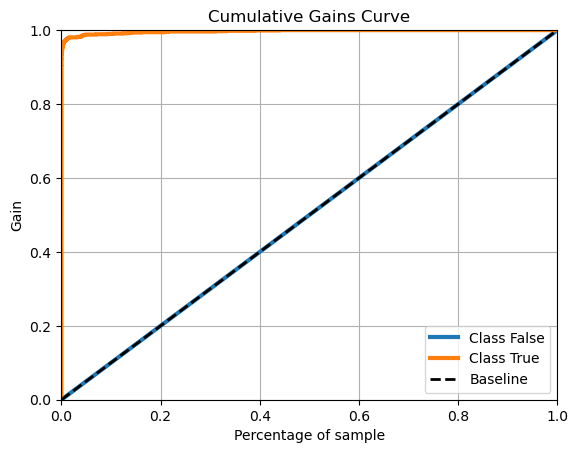

In [118]:
import scikitplot as skplt
skplt.metrics.plot_cumulative_gain(y_true=Y_c[['target']], y_probas =  probab_rf)
plt.show()

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


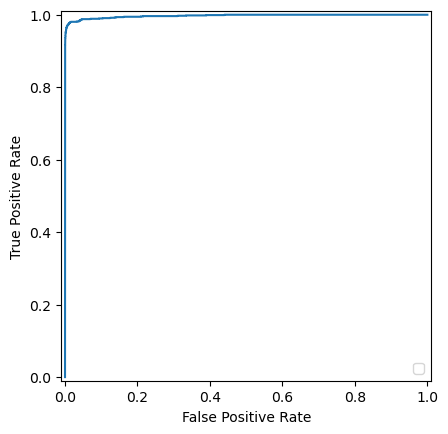

In [119]:
from sklearn.metrics import RocCurveDisplay, roc_curve

fpr, tpr, _ = roc_curve(Y_c[['target']], score_rf)
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr).plot()

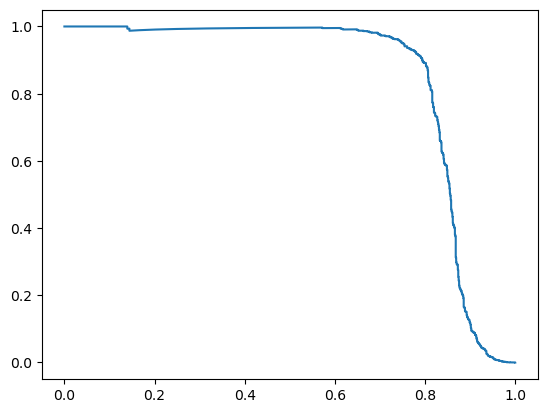

In [120]:
precision, recall, thresholds = skplt.metrics.precision_recall_curve(Y_c[['target']], score_rf)
plt.plot(recall, precision)

In [121]:
recall[recall>0.8].min() # 0.8010540184453228
precision[precision>0.8].min() #0.8002832861189801

0.8001824817518248

## Monthly overall alert analysis

In [122]:
pd.crosstab(testeo['mes'], Y_c['target'])

target,False,True
mes,,
1,3793133,168
2,3946058,86
3,4557576,98
4,4672224,124
5,5088628,106
6,5006912,145
7,4979507,116
8,2296945,68
9,2420668,75


In [123]:
Y_c['pred_corte_01'] = Y_c['score_rf']>corte_01
tes_corte_01 = testeo[Y_c['pred_corte_01']==True]
Y_c_corte_01 = Y_c[Y_c['pred_corte_01']==True]

pd.crosstab(tes_corte_01['mes'], Y_c_corte_01['target'])

target,False,True
mes,,
1,3743,168
2,3840,81
3,4281,90
4,4270,121
5,4171,106
6,5908,128
7,8263,89
8,2428,68
9,2566,72


In [124]:
Y_c

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
0,False,False,False,True,False,False,False,False,False,3.678008e-10,False,None,False,False,False,False,False
1,False,False,False,False,False,True,False,False,False,1.986804e-12,False,0,False,False,False,False,False
2,True,False,False,False,False,False,False,False,False,2.339633e-11,False,0,False,False,False,False,False
3,False,False,False,False,False,False,True,False,False,9.956241e-12,False,None,False,False,False,False,False
4,True,False,False,False,False,False,False,False,False,3.768772e-12,False,None,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43985869,True,False,False,False,False,False,False,False,False,4.172214e-12,False,0,False,False,False,False,False
43985870,False,False,True,False,False,False,False,False,False,5.181709e-12,False,0,False,False,False,False,False
43985871,False,False,True,False,False,False,False,False,False,9.504213e-10,False,0,False,False,False,False,False
43985872,False,False,False,False,False,False,True,False,False,4.076273e-10,False,0,False,False,False,False,False


# Monthly indicators

In [125]:
i = 0
summary_metrics = pd.DataFrame(columns = ['month','year', 'precision', 'recall','alerts','frauds&dist','frauds','detected'] )
for y in  testeo['year'].unique():
    for m in  testeo['mes'].unique():
        
        subset_mes = Y_c[(testeo['year']==y) & (testeo['mes']==m)]
        if not subset_mes.empty:
            precision = precision_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            recall = recall_score(subset_mes[['targetF']], subset_mes['pred_corte_01'])
            summary_metrics.loc[i,'month'] = m
            summary_metrics.loc[i,'year'] = y
            summary_metrics.loc[i,'precision'] = precision
            summary_metrics.loc[i,'recall'] = recall
            summary_metrics.loc[i,'alerts'] = subset_mes['pred_corte_01'].sum()
            summary_metrics.loc[i,'frauds'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds&dist'] = subset_mes['target'].sum()
            summary_metrics.loc[i,'frauds'] = (subset_mes['fraud_classification']=='Real').sum()
            summary_metrics.loc[i,'detected'] = ((subset_mes['pred_corte_01']==True) & (subset_mes['target']==True) & (subset_mes['fraud_classification']=='Real')).sum()
            #print ('Year:', y, 'Month:',m)
            #print ('Precision:', precision, 'Recall:',recall)
            i = i+1
summary_metrics.sort_values(['year','month'])

,month,year,precision,recall,alerts,frauds&dist,frauds,detected
3,1,2023,0.032405,1.0,1975,118,64,64
11,2,2023,0.015904,0.970588,2075,58,34,33
0,3,2023,0.009013,0.954545,2330,44,22,21
2,4,2023,0.024164,0.983607,2483,87,61,60
1,5,2023,0.018955,1.0,2374,69,45,45
7,6,2023,0.02807,0.914286,2280,101,70,64
8,7,2023,0.012479,1.0,2404,50,30,30
6,8,2023,0.014824,1.0,2496,68,37,37
10,9,2023,0.015542,0.931818,2638,75,44,41
9,10,2023,0.01183,1.0,2705,46,32,32


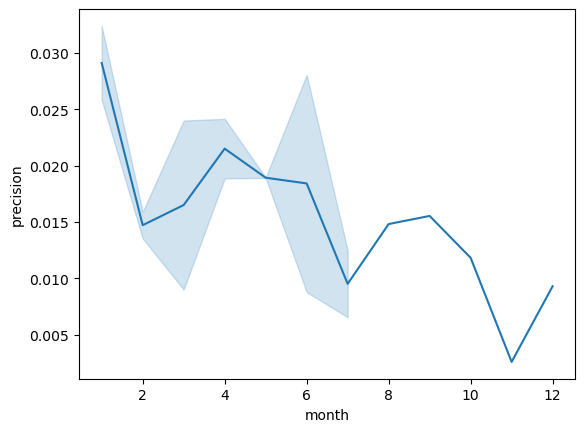

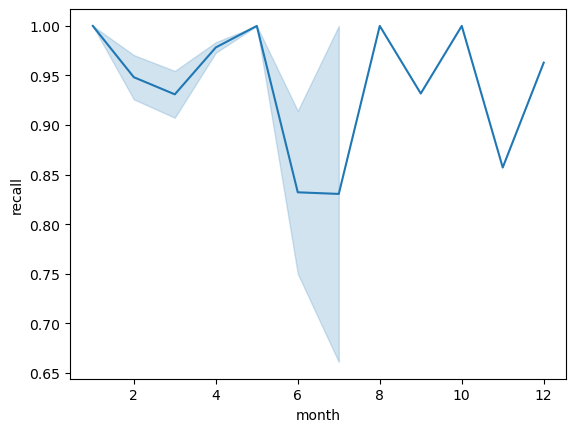

In [126]:
# Recall and precision by month
import seaborn as sns
sns.lineplot(data = summary_metrics, x ='month', y = 'precision')
plt.show()
sns.lineplot(data = summary_metrics, x ='month', y= 'recall')
plt.show()

## Daily analysis

In [127]:
tes_corte_01['date_receiver'].dt.floor('d')

28         2023-10-25
803        2023-04-02
2327       2023-09-29
3701       2024-05-03
4938       2023-06-11
              ...    
43982866   2024-07-01
43983245   2024-07-03
43983542   2024-07-20
43983561   2024-07-08
43984743   2024-07-30
Name: date_receiver, Length: 48211, dtype: datetime64[ns]

In [128]:
ALERTAS_01 = pd.crosstab(tes_corte_01['date_receiver'].dt.floor('d'), Y_c_corte_01['targetF'])
ALERTAS_01.to_csv ('./alertas.csv')

In [129]:
ALERTAS_01

targetF,False,True
date_receiver,,
2023-01-01,16,0
2023-01-02,59,0
2023-01-03,51,0
2023-01-04,69,11
2023-01-05,62,20
...,...,...
2024-07-27,272,0
2024-07-28,264,0
2024-07-29,259,0


In [130]:
FRAUDES = pd.crosstab(testeo['date_receiver'].dt.floor('d'), Y_c['targetF'])
#FRAUDES.to_csv ('./fraudes.csv')

In [131]:
FRAUDES

targetF,False,True
date_receiver,,
2023-01-01,15754,0
2023-01-02,58123,0
2023-01-03,48448,0
2023-01-04,44212,11
2023-01-05,43613,20
...,...,...
2024-07-27,120428,0
2024-07-28,110974,0
2024-07-29,84807,0


## Missing frauds

In [132]:
faltantes = (testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

pred_corte  pred_corte_01  pred_corte_02  pred_corte_03
True        True           True           True             23
False       False          False          False             5
True        False          False          False             1
Name: count, dtype: int64

In [133]:
X_faltantes[var_input].describe()

,branch_minutes_since_last_transaction,branch_trans_3m,branch_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,sender_nro_fraud,a_var_range_hist,sender_days_to_last_transaction_more7m,receiver_transaction_count,a_sender_sending_days,branch_working_days,a_net_amount_receiver,sender_minutes_since_last_transaction_2days,sender_days_to_last_transaction_365,sender_days_to_last_transaction_7m,a_hour_receiver
count,29.000000,29.000000,29.000000,25.000000,24.000000,16.0000,29.000000,29.000000,29.0,28.000000,29.0,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000,29.000000
mean,29.724138,1770.827586,14.310345,3.280000,1.791667,1.0625,14.310345,4.862069,0.0,1.717617,0.0,1.655172,0.086823,265.206897,0.325495,242.344828,11.655172,11.655172,0.844828
std,111.890219,7.531216,6.601425,1.275408,0.508977,0.2500,6.601425,3.632435,0.0,1.677932,0.0,1.631736,0.043726,0.412251,0.108017,722.106209,10.512835,10.512835,0.209786
min,0.000000,1760.000000,4.000000,1.000000,1.000000,1.0000,4.000000,0.000000,0.0,0.526316,0.0,1.000000,0.000000,265.000000,0.072202,0.000000,0.000000,0.000000,0.375000
25%,0.000000,1767.000000,11.000000,2.000000,1.750000,1.0000,11.000000,2.000000,0.0,0.815370,0.0,1.000000,0.044643,265.000000,0.270758,0.000000,2.000000,2.000000,0.916667
50%,2.000000,1769.000000,13.000000,4.000000,2.000000,1.0000,13.000000,4.000000,0.0,1.221591,0.0,1.000000,0.089286,265.000000,0.332130,0.000000,7.000000,7.000000,0.958333
75%,5.000000,1769.000000,13.000000,4.000000,2.000000,1.0000,13.000000,7.000000,0.0,1.734646,0.0,1.000000,0.123214,265.000000,0.379061,0.000000,22.000000,22.000000,0.958333
max,601.000000,1786.000000,25.000000,5.000000,3.000000,2.0000,25.000000,13.000000,0.0,8.235294,0.0,7.000000,0.142857,266.000000,0.577617,2865.000000,34.000000,34.000000,0.958333


In [134]:
#testeo.loc[(testeo['id_receiver'] ==5631) & (testeo['id_branch'] =='A24793')] 

testeo.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,fraud_classification_2,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,a_isMexico,a_sender_branch_state,a_var_range_hist,a_receiver_fraud,a_branch_fraud,a_location_fraud,a_sender_fraud,a_isCashPick,a_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,a_net_amount_receiver,a_receiver_transaction_count,a_sender_sending_days,a_sender_minutes_since_last_transaction_2days,a_sender_minutes_since_last_transaction_1day,a_sender_days_to_last_transaction_365,a_sender_days_to_last_transaction_7m,a_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,id_payout_G,target,year
492175,A24793,5651,2024-03-21 23:55:40.800,TX1505,T283,11336412,800.0,MEX,MEX21,TX,265,50.0,24.0,USA,Real,34940.0,0.0,24.0,None,1769.0,TX,13.0,NaN,4.0,2.0,1.0,13.0,3.0,1158.0,0,1,3,23,True,True,0.690846,False,True,True,False,False,True,24.0,0,24.0,0,0.0,0.0,0.288809,0.000000,0.089286,0.000000,0.000000,0.065753,0.114286,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,2024
1559024,A24793,5636,2024-03-21 23:41:51.120,TX1505,T239,10362492,1000.0,MEX,MEX5,TX,265,75.0,6.0,USA,Real,8821.0,79.0,6.0,None,1765.0,TX,9.0,NaN,NaN,NaN,NaN,9.0,6.0,725.0,0,1,3,23,True,True,1.379310,False,True,True,False,False,True,6.0,0,6.0,0,0.0,0.0,0.361011,0.000000,0.133929,0.000000,0.000000,0.016438,0.028571,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,2024
5075219,A24793,5641,2024-03-21 23:55:40.800,TX1505,T239,10365098,1200.0,MEX,MEX12,TX,265,76.0,1.0,USA,Real,1844.0,0.0,1.0,None,1769.0,TX,13.0,NaN,4.0,2.0,1.0,13.0,13.0,861.0,0,1,3,23,True,True,1.393728,False,True,True,False,False,True,1.0,0,1.0,0,1844.0,0.0,0.433213,0.000000,0.135714,0.640278,0.000000,0.002740,0.004762,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True,2024
5259679,A24793,5653,2024-03-21 23:55:40.800,TX1505,T057,10398602,650.0,MEX,MEX47,TX,265,36.0,7.0,USA,Real,10558.0,0.0,7.0,None,1769.0,TX,13.0,NaN,4.0,2.0,1.0,13.0,2.0,800.0,0,1,3,23,True,True,0.812500,False,True,True,False,False,True,7.0,0,7.0,0,0.0,0.0,0.234657,0.000000,0.064286,0.000000,0.000000,0.019178,0.033333,0.958333,False,False,False,True,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,2024
7110470,A24793,5654,2024-03-22 09:58:04.840,TX1505,T228,11270288,345.0,GUA,GUA6,TX,266,66.0,34.0,USA,0,48748.0,601.0,33.0,None,1781.0,TX,25.0,NaN,NaN,NaN,NaN,25.0,7.0,403.0,0,6,3,9,False,True,0.856079,False,True,True,False,True,False,34.0,0,34.0,0,0.0,0.0,0.124549,0.049505,0.117857,0.000000,0.000000,0.093151,0.161905,0.375000,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2024
7326869,A24793,5642,2024-03-21 23:55:40.800,TX1505,T239,10344170,1000.0,MEX,MEX44,TX,265,58.0,2.0,USA,Real,3422.0,2.0,2.0,None,1769.0,TX,13.0,NaN,4.0,2.0,1.0,13.0,4.0,1225

In [135]:
Y_c.loc[(testeo['id_receiver'].between(5631,5659)) & (testeo['id_branch'] =='A24793')] 

,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,target,preds_rf,score_rf,pred_corte,fraud_classification,targetF,pred_corte_01,pred_corte_02,pred_corte_03,pred_corte_04
492175,False,False,False,True,False,False,False,True,True,9.595710e-01,True,Real,True,True,True,True,True
1559024,False,False,False,True,False,False,False,True,True,8.554828e-01,True,Real,True,True,True,True,True
5075219,False,False,False,True,False,False,False,True,True,9.854360e-01,True,Real,True,True,True,True,True
5259679,False,False,False,True,False,False,False,True,True,9.405255e-01,True,Real,True,True,True,True,True
7110470,False,False,False,False,True,False,False,False,False,2.529616e-11,False,0,False,False,False,False,False
7326869,False,False,False,True,False,False,False,True,True,9.848521e-01,True,Real,True,True,True,True,True
11159524,False,False,False,True,False,False,False,True,True,9.409023e-01,True,Real,True,True,True,True,True
11781584,False,False,False,True,False,False,False,True,True,9.555258e-01,True,Real,True,True,True,True,True
12198643,False,False,False,True,False,False,False,True,True,9.922346e-01,True,Real,True,True,True,True,True
12783275,False,False,False,True,False,False,False,True,True,9.861235e-01,True,Real,True,True,True,True,True


In [136]:
Y_c.loc[(testeo['id_receiver'].between(1783,1783)) & (testeo['id_branch'] =='A20109'),'pred_corte_01'] 

10854647    True
Name: pred_corte_01, dtype: bool

In [137]:
testeo[(testeo['id_receiver'].between(1783,1783)) & (testeo['id_branch'] =='A20109')]

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,fraud_classification_2,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,a_isMexico,a_sender_branch_state,a_var_range_hist,a_receiver_fraud,a_branch_fraud,a_location_fraud,a_sender_fraud,a_isCashPick,a_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,a_net_amount_receiver,a_receiver_transaction_count,a_sender_sending_days,a_sender_minutes_since_last_transaction_2days,a_sender_minutes_since_last_transaction_1day,a_sender_days_to_last_transaction_365,a_sender_days_to_last_transaction_7m,a_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,id_payout_G,target,year
10854647,A20109,1783,2024-03-22 15:43:01.377,AR0206,T232,11581175,975.0,MEX,MEX11,AR,1262,0.0,0.0,USA,Real,0.0,101.0,0.0,None,135.0,AR,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,0,1,3,15,True,True,NaN,False,False,False,False,False,True,0.0,0,0.0,0,0.0,0.0,0.351986,0.0,0.0,0.0,0.0,0.0,0.0,0.625,False,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,True,False,True,2024


In [138]:
faltantes = (testeo['id_receiver'].between(174,178)) & (testeo['id_branch'] =='A25879')
X_faltantes = testeo[faltantes]
Y_c_faltantes = Y_c[faltantes]
Y_c_faltantes[['pred_corte','pred_corte_01','pred_corte_02','pred_corte_03']].value_counts()

pred_corte  pred_corte_01  pred_corte_02  pred_corte_03
True        True           True           True             5
Name: count, dtype: int64

In [139]:
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]
testeo[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883)]

,id_branch,id_receiver,date_receiver,id_location,id_payer,id_sender_global,net_amount_receiver,id_country_receiver_claim,id_state_receiver_claim,id_state,branch_working_days,sender_sending_days,sender_days_to_last_transaction,id_country,fraud_classification,sender_minutes_since_last_transaction,branch_minutes_since_last_transaction,sender_days_since_last_transaction,fraud_classification_2,branch_trans_3m,sender_state,branch_has_fraud,receiver_has_fraud,branch_trans_40min,branch_trans_10min,cash_pick_up_40min,location_nro_fraud,sender_trans_3m,range_hist,sender_nro_fraud,receiver_transaction_count,mes,hour_receiver,a_isMexico,a_sender_branch_state,a_var_range_hist,a_receiver_fraud,a_branch_fraud,a_location_fraud,a_sender_fraud,a_isCashPick,a_isBankDep,sender_days_to_last_transaction_365,sender_days_to_last_transaction_more365,sender_days_to_last_transaction_7m,sender_days_to_last_transaction_more7m,sender_minutes_since_last_transaction_2days,sender_minutes_since_last_transaction_1day,a_net_amount_receiver,a_receiver_transaction_count,a_sender_sending_days,a_sender_minutes_since_last_transaction_2days,a_sender_minutes_since_last_transaction_1day,a_sender_days_to_last_transaction_365,a_sender_days_to_last_transaction_7m,a_hour_receiver,day_name_receiver_0,day_name_receiver_1,day_name_receiver_2,day_name_receiver_3,day_name_receiver_4,day_name_receiver_5,day_name_receiver_6,id_payout_A,id_payout_C,id_payout_D,id_payout_M,id_payout_N,id_payout_O,id_payout_P,id_payout_S,id_payout_T,id_payout_X,targetR,targetP,id_payout_G,target,year
9171639,A24570,1883,2023-09-01 19:33:58.957,NY1438,T085,10617643,128.0,GUA,GUA11,NY,57,NaN,0.0,USA,None,0.0,6.0,0.0,None,1806.0,NY,0.0,0.0,7.0,2.0,7.0,0.0,0.0,NaN,0,4,9,19,False,True,NaN,False,False,False,False,True,False,0.0,0,0.0,0,0.0,0.0,0.046209,0.029703,NaN,0.0,0.0,0.0,0.0,0.791667,False,False,False,False,True,False,False,False,False,False,False,False,False,True,False,False,False,False,False,False,False,2023


In [140]:
s3_url = f"viamericas-datalake-dev-us-east-1-283731589572-raw/FraudModel/Data4Model/TargetTodos"
tes = pd.read_parquet(f"s3://{s3_url}/Data2024/Faltantes.parquet")

testeo2 = tes
Y_target2 = pd.DataFrame(tes['target']) 

In [141]:
testeo2['a_var_range_hist'] = testeo.loc[(testeo['id_branch']=='A24570') & (testeo['id_receiver']==1883),'a_var_range_hist']
testeo2['a_var_range_hist'] 

0   NaN
1   NaN
2   NaN
3   NaN
4   NaN
5   NaN
6   NaN
Name: a_var_range_hist, dtype: float64